# Training your MLP

In [1]:
%reset -f
import ipdb

import logging
import sys

my_stderr = sys.stderr = open('errors.txt', 'w')  # redirect stderr to file
get_ipython().log.handlers[0].stream = my_stderr  # log errors to new stderr
get_ipython().log.setLevel(logging.INFO)  # errors are logged at info level
LASER="LASER-master" # location of laser
mldir = "ml-training/SECRECY-EN/data" # training data and embeddings are held here
model_name = "SECRECY-EN"
edir = mldir + "/embed_simplified" # location of laser script that that embeds to LASER SS
languages = ['en','es'] # languages that are of interest for testing
languages_str = ' '.join(languages)
#embedding_name = 'LASER_USEm'
embedding_name = 'USEm'

In [2]:
# %matplotlib inline
import os
import math
import argparse
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from sklearn.metrics import classification_report
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import mplcursors
import pickle
import ast
from scipy.special import softmax

import ipdb

################################################

def LoadData(bdir, dfn, lfn, dim="{}", bsize=32, shuffle=False, quiet=False):
    
    embed_types = dfn.split('.')[1].split('_')
    split = dfn.split('.')[0]
    lang = dfn.split('.')[-1]
    dim = ast.literal_eval(dim)
        
    x_list = []
    for embdtyp in embed_types:
        dfn = '{}.{}.enc.{}'.format(split, embdtyp, lang)
        x = np.fromfile(bdir + dfn, dtype=np.float32, count=-1)
        x.resize(x.shape[0] // dim[embdtyp], dim[embdtyp])
        x_list.append(x)
    
    x = np.hstack(x_list)
    
    lbl = np.loadtxt(bdir + lfn, dtype=np.int32)
    lbl.reshape(lbl.shape[0], 1)
    if not quiet:
        print(' - read {:d}x{:d} elements in {:s}'.format(x.shape[0], x.shape[1], dfn))
        print(' - read {:d} labels [{:d},{:d}] in {:s}'
              .format(lbl.shape[0], lbl.min(), lbl.max(), lfn))

    D = data_utils.TensorDataset(torch.from_numpy(x), torch.from_numpy(lbl))
    loader = data_utils.DataLoader(D, batch_size=bsize, shuffle=shuffle)
    
    #ipdb.set_trace()
    
    return loader


################################################

def LoadData_pos(bdir, dfn, lfn, dim="{}", bsize=1, shuffle=True, quiet=False):
    embed_types = dfn.split('.')[1].split('_')
    split = dfn.split('.')[0]
    lang = dfn.split('.')[-1]
    dim = ast.literal_eval(dim)
        
    x_list = []
    for embdtyp in embed_types:
        dfn = '{}.{}.enc.{}'.format(split, embdtyp, lang)
        x = np.fromfile(bdir + dfn, dtype=np.float32, count=-1)
        x.resize(x.shape[0] // dim[embdtyp], dim[embdtyp])
        x_list.append(x)
    
    x = np.hstack(x_list)

    lbl = np.loadtxt(bdir + lfn, dtype=np.int32)
    lbl.reshape(lbl.shape[0], 1)
    
    x_pos = x[lbl==1]
    lbl_pos = lbl[lbl==1]
    
    if not quiet:
        print(' - read {:d}x{:d} elements in {:s}'.format(x.shape[0], x.shape[1], dfn))
        print(' - read {:d} labels [{:d},{:d}] in {:s}'
              .format(lbl.shape[0], lbl.min(), lbl.max(), lfn))

    D = data_utils.TensorDataset(torch.from_numpy(x_pos), torch.from_numpy(lbl_pos))
    loader = data_utils.DataLoader(D, batch_size=bsize, shuffle=shuffle)
    
    #ipdb.set_trace()
    
    return loader


################################################

def LoadText(bdir, dfn, lfn, dim="{}", bsize=32, shuffle=False, quiet=False):
    #file_name = (bdir + dfn).replace('laser_usem.enc','txt')
    file_name = (bdir + dfn).replace(embedding_name + '.enc','txt')
    txt = np.loadtxt(file_name,dtype=object, delimiter='\n',comments=None)

    lbl = np.loadtxt(bdir + lfn, dtype=np.int32)
    lbl.reshape(lbl.shape[0], 1)
    if not quiet:
        print(' - read {:d} text elements in {:s}'.format(txt.shape[0], file_name))
        print(' - read {:d} labels [{:d},{:d}] in {:s}'
              .format(lbl.shape[0], lbl.min(), lbl.max(), lfn))

    assert txt.shape[0] == lbl.shape[0] , 'Mismatched Dimensions While Loading Text'
    return {'text':txt, 'labels':lbl}


################################################

def LoadTrainDevData(bdir, dfn_train, lfn_train, dfn_dev, lfn_dev ,dim="{}", bsize=32, shuffle=False, quiet=False):

#     x_train = np.fromfile(bdir + dfn_train, dtype=np.float32, count=-1)
#     x_train.resize(x_train.shape[0] // dim, dim)
        
    embed_types = dfn_train.split('.')[1].split('_')
    split = dfn_train.split('.')[0]
    lang = dfn_train.split('.')[-1]
    dim = ast.literal_eval(dim)
        
    x_train_list = []
    for embdtyp in embed_types:
        dfn_train = '{}.{}.enc.{}'.format(split, embdtyp, lang)
        x_train = np.fromfile(bdir + dfn_train, dtype=np.float32, count=-1)
        x_train.resize(x_train.shape[0] // dim[embdtyp], dim[embdtyp])
        x_train_list.append(x_train)
    
    x_train = np.hstack(x_train_list)    

    lbl_train = np.loadtxt(bdir + lfn_train, dtype=np.int32)
    lbl_train.reshape(lbl_train.shape[0], 1)

    ######
    
#     x_dev = np.fromfile(bdir + dfn_dev, dtype=np.float32, count=-1)
#     x_dev.resize(x_dev.shape[0] // dim, dim)

    embed_types = dfn_dev.split('.')[1].split('_')
    split = dfn_dev.split('.')[0]
    lang = dfn_dev.split('.')[-1]    
        
    x_dev_list = []
    for embdtyp in embed_types:
        dfn_dev = '{}.{}.enc.{}'.format(split, embdtyp, lang)
        x_dev = np.fromfile(bdir + dfn_dev, dtype=np.float32, count=-1)
        x_dev.resize(x_dev.shape[0] // dim[embdtyp], dim[embdtyp])
        x_dev_list.append(x_dev)
    
    x_dev = np.hstack(x_dev_list)    
    
    
    lbl_dev = np.loadtxt(bdir + lfn_dev, dtype=np.int32)
    lbl_dev.reshape(lbl_dev.shape[0], 1)
        
    x = np.vstack((x_train,x_dev))
    lbl = np.concatenate((lbl_train,lbl_dev), axis=0)
        
    if not quiet:
        print(' - read {:d}x{:d} elements in {:s}'.format(x.shape[0], x.shape[1], dfn_train + dfn_dev))
        print(' - read {:d} labels [{:d},{:d}] in {:s}'
              .format(lbl.shape[0], lbl.min(), lbl.max(), lfn_train + lfn_dev))

    D = data_utils.TensorDataset(torch.from_numpy(x), torch.from_numpy(lbl))
    loader = data_utils.DataLoader(D, batch_size=bsize, shuffle=shuffle)
    
    #ipdb.set_trace()
    
    return loader

################################################

def LoadTrainDevData_pos(bdir, dfn_train, lfn_train, dfn_dev, lfn_dev, dim="{}", bsize=1, shuffle=True, quiet=False):
#     x_train = np.fromfile(bdir + dfn_train, dtype=np.float32, count=-1)
#     x_train.resize(x_train.shape[0] // dim, dim)
    
    embed_types = dfn_train.split('.')[1].split('_')
    split = dfn_train.split('.')[0]
    lang = dfn_train.split('.')[-1]
    dim = ast.literal_eval(dim)
        
    x_train_list = []
    for embdtyp in embed_types:
        dfn_train = '{}.{}.enc.{}'.format(split, embdtyp, lang)
        x_train = np.fromfile(bdir + dfn_train, dtype=np.float32, count=-1)
        x_train.resize(x_train.shape[0] // dim[embdtyp], dim[embdtyp])
        x_train_list.append(x_train)
    
    x_train = np.hstack(x_train_list)    
    lbl_train = np.loadtxt(bdir + lfn_train, dtype=np.int32)
    lbl_train.reshape(lbl_train.shape[0], 1)

    ######
    
#     x_dev = np.fromfile(bdir + dfn_dev, dtype=np.float32, count=-1)
#     x_dev.resize(x_dev.shape[0] // dim, dim)

    embed_types = dfn_dev.split('.')[1].split('_')
    split = dfn_dev.split('.')[0]
    lang = dfn_dev.split('.')[-1]
        
    x_dev_list = []
    for embdtyp in embed_types:
        dfn_dev = '{}.{}.enc.{}'.format(split, embdtyp, lang)
        x_dev = np.fromfile(bdir + dfn_dev, dtype=np.float32, count=-1)
        x_dev.resize(x_dev.shape[0] // dim[embdtyp], dim[embdtyp])
        x_dev_list.append(x_dev)
    
    x_dev = np.hstack(x_dev_list)    
    lbl_dev = np.loadtxt(bdir + lfn_dev, dtype=np.int32)
    lbl_dev.reshape(lbl_dev.shape[0], 1)
    
    ######
    
    x = np.vstack((x_train,x_dev))
    lbl = np.concatenate((lbl_train,lbl_dev), axis=0)
        
    x_pos = x[lbl==1]
    lbl_pos = lbl[lbl==1]
    
    if not quiet:
        print(' - read {:d}x{:d} elements in {:s}'.format(x_pos.shape[0], x_pos.shape[1], dfn_train + dfn_dev))
        print(' - read {:d} labels [{:d},{:d}] in {:s}'
              .format(lbl_pos.shape[0], lbl_pos.min(), lbl_pos.max(), lfn_train + lfn_dev))

    D = data_utils.TensorDataset(torch.from_numpy(x_pos), torch.from_numpy(lbl_pos))    
    loader = data_utils.DataLoader(D, batch_size=bsize, shuffle=shuffle)
    
    #ipdb.set_trace()
    
    return loader


################################################


class Net(nn.Module):
    def __init__(self, idim="{}", odim=2, nhid=None,
                 dropout=0.0, gpu=0, activation='RELU'):
        super(Net, self).__init__()
        
        idim = ast.literal_eval(idim)
        idim = sum([i for i in list(idim.values())])
        
        self.gpu = gpu
        modules = []

        modules = []
        print(' - mlp {:d}'.format(idim), end='')
        if len(nhid) > 0:
            if dropout > 0:
                modules.append(nn.Dropout(p=dropout))
            nprev = idim
            for nh in nhid:
                if nh > 0:
                    modules.append(nn.Linear(nprev, nh))
                    nprev = nh
                    if activation == 'TANH':
                        modules.append(nn.Tanh())
                        print('-{:d}t'.format(nh), end='')
                    elif activation == 'RELU':
                        modules.append(nn.ReLU())
                        print('-{:d}r'.format(nh), end='')
                    else:
                       raise Exception('Unrecognized activation {activation}')
                    if dropout > 0:
                        modules.append(nn.Dropout(p=dropout))
            modules.append(nn.Linear(nprev, odim))
            print('-{:d}, dropout={:.1f}'.format(odim, dropout))
        else:
            modules.append(nn.Linear(idim, odim))
            print(' - mlp %d-%d'.format(idim, odim))
        self.mlp = nn.Sequential(*modules)
        # Softmax is included CrossEntropyLoss !

        if self.gpu >= 0:
            self.mlp = self.mlp.cuda()

    def forward(self, x):
        return self.mlp(x)

    def TestCorpus(self, dset, name='', nlbl=2):
        correct = 0
        total = 0
        self.mlp.train(mode=False)
        corr = np.zeros(nlbl, dtype=np.int32)
        for data in dset:
            X, Y = data
            Y = Y.long()
            if self.gpu >= 0:
                X = X.cuda()
                Y = Y.cuda()
            outputs = self.mlp(X)
            _, predicted = torch.max(outputs.data, 1)
            total += Y.size(0)
            correct += (predicted == Y).int().sum()
            for i in range(nlbl):
                corr[i] += (predicted == i).int().sum()

        print(' | {:4s}: {:5.2f}%'
                         .format(name, 100.0 * correct.float() / total), end='')
        print(' | classes:', end='')
        for i in range(nlbl):
            print(' {:5.2f}'.format(100.0 * corr[i] / total), end='')

        return correct, total

    # net_best.TestCorpus_cstm(test_loader, 'Test',nlbl=args.nb_classes, txt=test_txt)
    # have this function output a dataframe with confidence scores!
    def TestCorpus_cstm(self, dset, name='', nlbl=2, txt=None, return_df=False, verbose=False):
        correct = 0
        total = 0
        self.mlp.train(mode=False)
        corr = np.zeros(nlbl, dtype=np.int32)
        
        if args.gpu >= 0:
            criterion = nn.CrossEntropyLoss().cuda()
        else:
            criterion = nn.CrossEntropyLoss()

        Y_all = torch.empty(0, dtype=torch.int64)
        predicted_all = torch.empty(0, dtype=torch.int64)
        loss_all = 0
        probs_all = []
        batches = 0
#         for data in dset:
        for i, data in enumerate(dset, 0):
            X, Y = data
            Y = Y.long()
            Y_all = torch.cat((Y_all,Y))
            if self.gpu >= 0:
                X = X.cuda()
                Y = Y.cuda()
            outputs = self.mlp(X)
            # convert to probabilities:
            scores = outputs.detach().numpy()
            probs = softmax(scores, axis=1)
            probs = [x[1] for x in probs.tolist()]
            probs_all = probs_all + probs
            _, predicted = torch.max(outputs.data, 1) # outputs are the model scores
            if (txt!=None) & (i%100==0):
                if verbose:
                    print('len(data), len(probs), len(predicted)')
                    print(len(data[0]), len(probs), len(predicted.cpu()))
                    print('data:')
                    print(data)
                    print('Probs:')
                    print(probs)
                    print('outputs.data:')
                    print(pd.DataFrame(outputs.data).astype(float))
                    print('predicted:')
                    print(predicted)
                    #return 0
            predicted_all = torch.cat((predicted_all,predicted.cpu()))
            total += Y.size(0)
            correct += (predicted == Y).int().sum()
            for i in range(nlbl):
                corr[i] += (predicted == i).int().sum()
                
            loss_all += criterion(outputs, Y)
            batches += 1
        
        # all predictions
        if (txt!=None) & (return_df):
            #print(predicted_all) # or print dataframe
            # TO DO: add column with model scores instead of class predictions
            #print('len text, labels, predictions, model_scores')
            #print(len(txt['text']), len(txt['labels']), len(predicted_all.tolist()), len(probs_all))
            df = pd.DataFrame({'text': txt['text'], 'labels': txt['labels'], 'predictions': predicted_all.tolist(), 'model_scores': probs_all})
            if verbose:
                print('Test Dataframe:')
                print(df)
        
        avg_loss = loss_all/float(batches)
        print(' | {:4s}: {:5.2f}%'
                         .format(name, 100.0 * correct.float() / total), end='')
        print(' | classes:', end='')
        for i in range(nlbl):
            print(' {:5.2f}'.format(100.0 * corr[i] / total), end='')
        
        clf_report = classification_report(Y_all, predicted_all, output_dict=True)
        print('\n')
        print(classification_report(Y_all, predicted_all))
        
        # Fail State Analysis
        FP = []
        FN = []
        TP = []
        if txt is not None:
            for idx, txt_label in enumerate(txt['labels']):
                assert txt_label == Y_all[idx].item(), 'Mismatched labels'
                
                # TP
                if (Y_all[idx].item() == 1) and (predicted_all[idx].item() == 1):
                    TP.append((idx, txt['text'][idx]))

                # FP
                if (Y_all[idx].item() == 0) and (predicted_all[idx].item() == 1):
                    FP.append((idx, txt['text'][idx]))
                
                # FN
                if (Y_all[idx].item() == 1) and (predicted_all[idx].item() == 0):
                    FN.append((idx, txt['text'][idx]))

            fail_state = {'TP':TP,'FP':FP,'FN':FN}
            clf_report['fail_state'] = fail_state
                    

        if return_df:
            return correct, total, avg_loss, clf_report, df
        else:
            return correct, total, avg_loss, clf_report


################################################

In [3]:
#net_best_.TestCorpus_cstm(test_loader_, 'Test',nlbl=nb_classes_, txt=test_txt_)

In [4]:
parser = argparse.ArgumentParser(
           formatter_class=argparse.RawDescriptionHelpFormatter,
           description="Simple sentence classifier")

# Data
parser.add_argument('--base-dir', '-b', type=str, required=True, metavar='PATH',help="Directory with all the data files)")
parser.add_argument('--plot-name', '-p', type=str, required=True, metavar='PATH',help="name of plot file")
parser.add_argument('--save', '-s', type=str, required=False, metavar='PATH', default="",help="File in which to save best network")
parser.add_argument('--train', '-t', type=str, required=True, metavar='STR',help="Name of training corpus")
parser.add_argument('--train-labels', '-T', type=str, required=True, metavar='STR',help="Name of training corpus (labels)")
parser.add_argument('--dev', '-d', type=str, required=True, metavar='STR',help="Name of development corpus")
parser.add_argument('--dev-labels', '-D', type=str, required=True, metavar='STR',help="Name of development corpus (labels)")
parser.add_argument('--test', '-e', type=str, required=True, metavar='STR',help="Name of test corpus without language extension")
parser.add_argument('--test-labels', '-E', type=str, required=True, metavar='STR',help="Name of test corpus without language extension (labels)")
parser.add_argument('--lang', '-L', nargs='+', default=None,help="List of languages to test on")

# network definition
parser.add_argument("--dim", "-m", type=str, default="{}",help="Dimension of sentence embeddings")
parser.add_argument('--nhid', '-n', type=int, default=[0], nargs='+',help="List of hidden layer(s) dimensions")
parser.add_argument("--nb-classes", "-c", type=int, default=2,help="Number of output classes")
parser.add_argument('--dropout', '-o', type=float, default=0.0, metavar='FLOAT',help="Value  of dropout")
parser.add_argument('--nepoch', '-N', type=int, default=100, metavar='INT',help="Number of epochs")
parser.add_argument('--bsize', '-B', type=int, default=128, metavar='INT',help="Batch size")
parser.add_argument('--seed', '-S', type=int, default=123456789, metavar='INT',help="Initial random seed")
parser.add_argument('--lr', type=float, default=0.001, metavar='FLOAT',help='Learning rate')
parser.add_argument('--wdecay', type=float, default=0.0, metavar='FLOAT',help='Weight decay')
parser.add_argument('--gpu', '-g', type=int, default=-1, metavar='INT',help="GPU id (-1 for CPU)")

ltrn = 'en' # change for spanish
ldev = ltrn
nb_cl=2
N=100
lr=0.001
wd=0.0

# for laser+usem
#dim = {'usem':512,'laser':1024}

# for usem only
#dim = {'usem':512}
dim = {embedding_name:512}

# nhid=['256','128']
nhid=['768','128']
gpu='-1'

drop=0.5
seed=1
bsize=512
plot_name = model_name + "_lr_wd_" + model_name + ".png"
save_model = model_name + "_best_model_test_" + embedding_name

args_list = ['--gpu', gpu,
            '--base-dir', edir,
            #'--train', "train.{}.enc.".format(embedding_name.lower())+ltrn,
            '--train', "train.{}.enc.".format(embedding_name)+ltrn, 
            '--train-labels', "train.lbl."+ltrn,
            #'--dev', "dev.{}.enc.".format(embedding_name.lower())+ldev,
            '--dev', "dev.{}.enc.".format(embedding_name)+ldev,
            '--dev-labels', "dev.lbl."+ldev,
            #'--test', "test.{}.enc".format(embedding_name.lower()),
            '--test', "test.{}.enc".format(embedding_name),
            '--test-labels', "test.lbl",
            '--dim', str(dim),
            '--nb-classes', str(nb_cl),
            '--nhid', *nhid,
            '--dropout', str(drop),
            '--bsize', str(bsize),
            '--seed', str(seed),
            '--lr', str(lr),
            '--wdecay', str(wd),
            '--nepoch', str(N),
            '--lang', *languages,
            '--save', save_model,
            '--plot-name', plot_name]

args = parser.parse_args(args_list)
print(' - base directory: {}'.format(args.base_dir))
args.base_dir = args.base_dir + "/"

 - base directory: ml-training/SECRECY-EN/data/embed_simplified


 - setting seed to 1
 - read 10600x512 elements in train.USEm.enc.en
 - read 10600 labels [0,1] in train.lbl.en
 - mlp 512-768r-128r-2, dropout=0.5
num: 20
final_value: 10.0
init_value: 0.0001
 - read 10600x512 elements in train.USEm.enc.en
 - read 10600 labels [0,1] in train.lbl.en
 - mlp 512-768r-128r-2, dropout=0.5
num: 20
final_value: 10.0
init_value: 0.0001
 - read 10600x512 elements in train.USEm.enc.en
 - read 10600 labels [0,1] in train.lbl.en
 - mlp 512-768r-128r-2, dropout=0.5
num: 20
final_value: 10.0
init_value: 0.0001
 - read 10600x512 elements in train.USEm.enc.en
 - read 10600 labels [0,1] in train.lbl.en
 - mlp 512-768r-128r-2, dropout=0.5
num: 20
final_value: 10.0
init_value: 0.0001
 - read 10600x512 elements in train.USEm.enc.en
 - read 10600 labels [0,1] in train.lbl.en
 - mlp 512-768r-128r-2, dropout=0.5
num: 20
final_value: 10.0
init_value: 0.0001


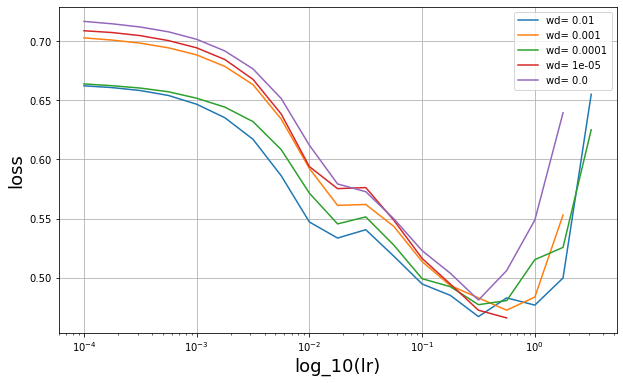

In [5]:
# PURPOSE OF THIS CELL IS TO FIND OPTIMAL VALUE OF LR AND WD
# SEE https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
# note this is done using only the training set, no dev set required

def find_lr_wd(args, init_value = 1e-4, final_value=10., beta = 0.98, wd = [1e-2, 1e-3, 1e-4, 1e-5, 0.0]):
    
    # set GPU and random seed
    torch.cuda.set_device(args.gpu)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    print(" - setting seed to %d" % args.seed)

    wd_lr_loss = {}
    plt.figure(figsize=(10,6))


######################

######################
    


    for wd_i in wd:    
        train_loader = LoadData(args.base_dir, args.train, args.train_labels,
                            dim=args.dim, bsize=args.bsize, shuffle=True)

        # create network
        net = Net(idim=args.dim, odim=args.nb_classes,
                  nhid=args.nhid, dropout=args.dropout, gpu=args.gpu)
        if args.gpu >= 0:
            criterion = nn.CrossEntropyLoss().cuda()
        else:
            criterion = nn.CrossEntropyLoss()

        optimizer = optim.AdamW(net.parameters(),
                               lr=args.lr,
                               weight_decay=wd_i,
                               betas=(0.9, 0.999),
                               eps=1e-8,
                               amsgrad=False)

        num = len(train_loader)-1
        print("num: {}".format(num))
        print("final_value: {}".format(final_value))
        print("init_value: {}".format(init_value))
        mult = (final_value / init_value) ** (1/num)
        lr = init_value

        optimizer.param_groups[0]['lr'] = lr
        avg_loss = 0.
        best_loss = 0.
        batch_num = 0
        losses = []
        lrs = []

        for i, data in enumerate(train_loader, 0):
            batch_num += 1
            # get the inputs
            inputs, labels = data
            labels = labels.long()
            if args.gpu >= 0:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # zero the parameter gradients
            net.zero_grad()

            # forward + backward + optimize
            net.train(mode=True)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            #Compute the smoothed loss
            avg_loss = beta * avg_loss + (1-beta) *loss.data.item()
            smoothed_loss = avg_loss / (1 - beta**batch_num)

            #Stop if the loss is exploding
            if batch_num > 1 and smoothed_loss > 4 * best_loss:
                wd_lr_loss[wd_i] = {'lrs':lrs, 'losses':losses}
                break

            #Record the best loss
            if smoothed_loss < best_loss or batch_num==1:
                best_loss = smoothed_loss

            #Store the values
            losses.append(smoothed_loss)
            lrs.append(lr)

            #Do the SGD step
            loss.backward()
            optimizer.step()            

            #Update the lr for the next step
            lr *= mult
            optimizer.param_groups[0]['lr'] = lr
            
        wd_lr_loss[wd_i] = {'lrs':lrs, 'losses':losses}

        plt.plot(lrs,losses,label='wd= '+str(wd_i))
    
    plt.legend(loc='best')
    plt.xlabel('log_10(lr)',fontsize=18)
    plt.ylabel('loss',fontsize=18)
    plt.xticks(np.linspace(init_value, final_value,10))
    plt.xscale("log")
    plt.grid()
    plt.savefig(args.plot_name)
            
    return wd_lr_loss

wd_lr_loss = find_lr_wd(args)

In [6]:
# looks like optimal wd is 0.0
# optimal lr (where loss is decreasing the fastest) is around 10^-2 (0.01)
lr_opt = 0.01
wd_opt = 0.0

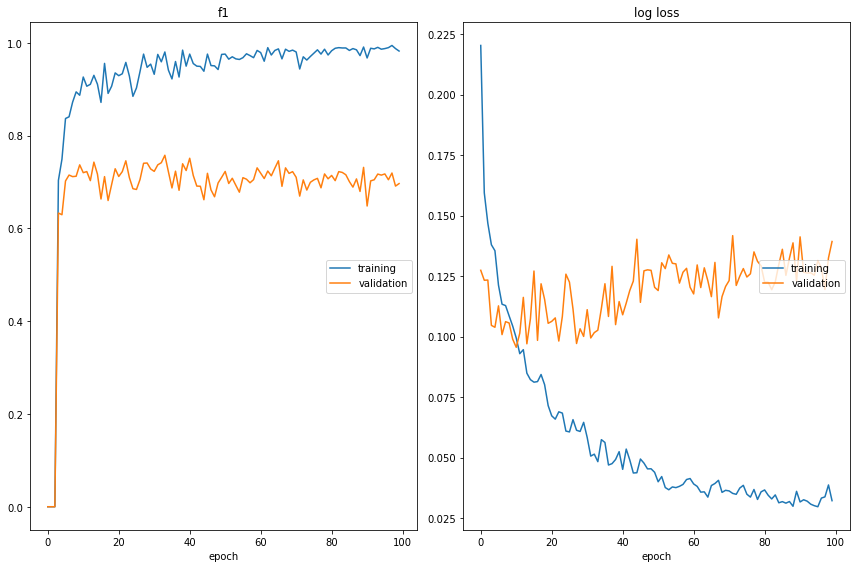

f1
	training         	 (min:    0.000, max:    0.995, cur:    0.983)
	validation       	 (min:    0.000, max:    0.758, cur:    0.697)
log loss
	training         	 (min:    0.030, max:    0.220, cur:    0.032)
	validation       	 (min:    0.096, max:    0.142, cur:    0.139)


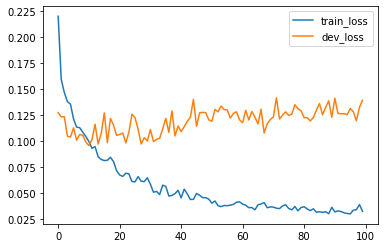

SECRECY-EN_best_model_test_USEm
Best Dev: 33 epochs. Best f1 score is 75.78%
****************
****************
****************
****************
Ep best | Eval Test lang en

 | Test: 98.91% | classes: 98.33  1.67

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     34483
           1       0.56      0.73      0.63       451

    accuracy                           0.99     34934
   macro avg       0.78      0.86      0.81     34934
weighted avg       0.99      0.99      0.99     34934



Ep best | Eval Test lang es

 | Test: 95.25% | classes: 94.72  5.28

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      4080
           1       0.25      0.62      0.36        90

    accuracy                           0.95      4170
   macro avg       0.62      0.79      0.67      4170
weighted avg       0.98      0.95      0.96      4170





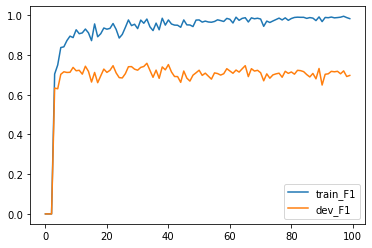

In [7]:
# PURPOSE OF THIS CELL IS TO FIND OPTIMAL BUMBER OF EPOCHS
# at every epoch from 1 to 100, we train a nn on the train set and evaluate on the dev set.
# we save the optimal epoch (in terms of f1), the f1 score, and the trained net
# finally, we predict on the test set (not dev) with net_best. Note that net_best was trained only on train, not train+dev

# optimal hyperparams from the previous cell
#lr_opt = 0.001
#wd_opt = 0.0

args.nepoch = 1§00
args.training_plot = model_name + "_nepoch_" + model_name + ".png"
args.lr = lr_opt
args.wdecay = wd_opt
# train only training data
def dev_train_mlp(args):
        
    liveloss = PlotLosses()

    train_loader = LoadData(args.base_dir, args.train, args.train_labels,
                            dim=args.dim, bsize=args.bsize, shuffle=True)

    train_pos = LoadData_pos(args.base_dir, args.train, args.train_labels,
                            dim=args.dim, bsize=1, shuffle=True)

    dev_loader = LoadData(args.base_dir, args.dev, args.dev_labels,
                          dim=args.dim, bsize=args.bsize, shuffle=False)

    dev_text = LoadText(args.base_dir, args.dev, args.dev_labels,
                        dim=args.dim, bsize=args.bsize, shuffle=False)

    
    # set GPU and random seed
    torch.cuda.set_device(args.gpu)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    print(" - setting seed to %d" % args.seed)

    # create network
    net = Net(idim=args.dim, odim=args.nb_classes,
              nhid=args.nhid, dropout=args.dropout, gpu=args.gpu)
    if args.gpu >= 0:
        criterion = nn.CrossEntropyLoss().cuda()
    else:
        criterion = nn.CrossEntropyLoss()

    #optimizer = optim.Adam(net.parameters(), weight_decay=0.0)
    # default: pytorch/optim/adam.py
    # Py0.4: lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False):
    # Py1.0: lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False):
    optimizer = optim.AdamW(net.parameters(),
                           lr=args.lr,
                           weight_decay=args.wdecay,
                           betas=(0.9, 0.999),
                           eps=1e-8,
                           amsgrad=False)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
    #                                                max_lr=args.lr,
    #                                                steps_per_epoch=len(train_loader),
    #                                                epochs=args.nepoch)
    
    epoch_train_loss = []
    epoch_dev_loss = []
    epoch_train_f1 = []
    epoch_dev_f1 = []
    epoch_id = []
    
    corr_best = 0
    f1_best = 0
    # loop multiple times over the dataset
    for epoch in range(args.nepoch):
        logs = {}

        loss_epoch = 0.0
        print('Ep {:4d}'.format(epoch), end='')
        # for inputs, labels in train_loader:
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data

            # augment with pos sample
            if data[1][data[1]==1].shape[0] == 0:
                aug_data_pos = iter(train_pos).next()
                inputs = torch.cat([inputs,aug_data_pos[0]])
                labels = torch.cat([labels,aug_data_pos[1]])
            
            labels = labels.long()
            if args.gpu >= 0:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # zero the parameter gradients            
            net.zero_grad()

            # forward + backward + optimize
            net.train(mode=True)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            #for param_group in optimizer.param_groups:
            #    print(param_group['lr'])          
            #scheduler.step()

            loss_epoch += loss.item()
            
            torch.cuda.empty_cache()
            
            
        print(' | loss {:e}'.format(loss_epoch), end='')
        print('\n')
        torch.cuda.empty_cache()
        _, _, _, train_clf_reprt = net.TestCorpus_cstm(train_loader, 'Train',nlbl=args.nb_classes)
        torch.cuda.empty_cache()
        del _
        # return correct, total, avg_loss, clf_report
        corr, nbex, dev_loss, dev_clf_reprt = net.TestCorpus_cstm(dev_loader, 'Dev', nlbl=args.nb_classes, txt=dev_text, verbose=False)
        
        # Epoch metrics (train/dev, loss/F1)
        f1 = dev_clf_reprt['1']['f1-score']
        
        epoch_id.append(epoch)
        
        epoch_train_loss.append(loss_epoch/float(i))
        epoch_dev_loss.append(dev_loss.item())
        
        epoch_train_f1.append(train_clf_reprt['1']['f1-score'])
        epoch_dev_f1.append(dev_clf_reprt['1']['f1-score'])
        
        
        # Keeping Record of Best MLP net (based on Dev set)
        #if corr >= corr_best:
        if f1 >= f1_best:
            print(' | saved')
            f1_best = f1
            epoch_best = epoch
            net_best = copy.deepcopy(net)
        else:
            print('')
                    
        ## Plot epochs metrics 
        logs['' + 'log loss'] = loss_epoch/float(i)
        logs['' + 'f1'] = train_clf_reprt['1']['f1-score']
        logs['val_' + 'log loss'] = dev_loss.item()
        logs['val_' + 'f1'] = dev_clf_reprt['1']['f1-score']
        
        liveloss.update(logs)
        liveloss.draw()
        
        torch.cuda.empty_cache()

    plt.plot(epoch_id, epoch_train_loss, label='train_loss')
    plt.plot(epoch_id, epoch_dev_loss, label='dev_loss')
    plt.legend(loc='best')
    plt.show()

    plt.plot(epoch_id, epoch_train_f1, label='train_F1')
    plt.plot(epoch_id, epoch_dev_f1, label='dev_F1')
    plt.legend(loc='best')
    plt.savefig(args.training_plot)
    

    # Saving best MLP net and Producing Zero-Shot Multilingual Results
    if args.save != '':
        torch.save(net_best.cpu(), args.save+'_dev')
        print(args.save)
    print('Best Dev: {:d} epochs. Best f1 score is {:5.2f}%'.format(epoch_best, 100.0 * f1_best))
    print('****************\n****************\n****************\n****************')

    if args.gpu >= 0:
        net_best = net_best.cuda()

    # test on (several) languages
    test_clf_reprt = {}
    for l in args.lang:
        test_loader = LoadData(args.base_dir, args.test + '.' + l,
                               args.test_labels + '.' + l,
                               dim=args.dim, bsize=args.bsize,
                               shuffle=False, quiet=True)

        test_txt = LoadText(args.base_dir, args.test + '.' + l,
                               args.test_labels + '.' + l,
                               dim=args.dim, bsize=args.bsize,
                               shuffle=False, quiet=True)

        print('Ep best | Eval Test lang {:s}'.format(l), end='')
        print('\n')
        _, _, _, test_clf_reprt[l] = net_best.TestCorpus_cstm(test_loader, 'Test',nlbl=args.nb_classes, txt=test_txt)
        print('\n')
    
    pickle.dump(test_clf_reprt, open( save_model+'_test_metrics_w_dev_model.pkl', "wb" )) 
        
        
dev_train_mlp(args)


In [8]:
# record the optimal number of epochs
epochs_opt = 27

In [9]:
print(lr_opt)
print(wd_opt)
print(epochs_opt)

0.01
0.0
27


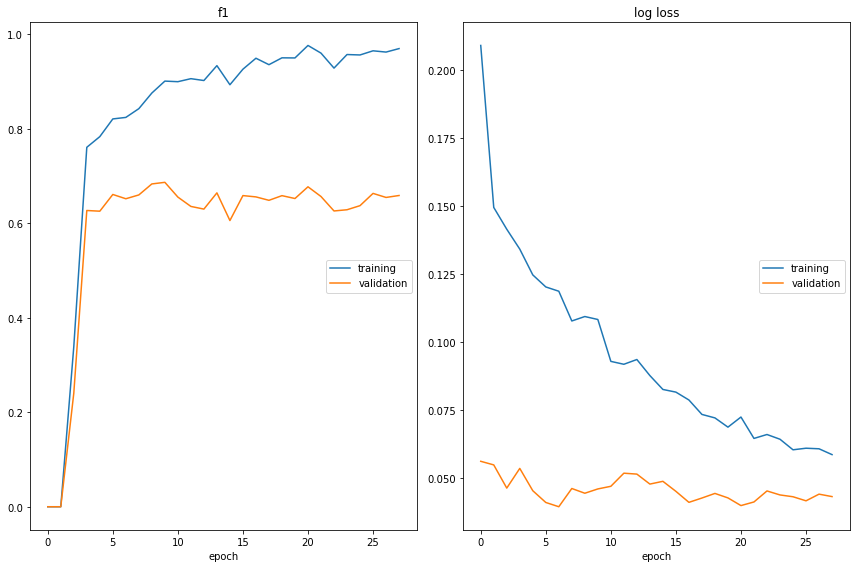

f1
	training         	 (min:    0.000, max:    0.977, cur:    0.970)
	validation       	 (min:    0.000, max:    0.687, cur:    0.659)
log loss
	training         	 (min:    0.059, max:    0.209, cur:    0.059)
	validation       	 (min:    0.040, max:    0.056, cur:    0.043)


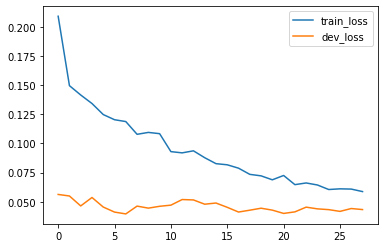

SECRECY-EN_best_model_test_USEm
Best Dev: 27 = 65.91%
Ep best | Eval Test lang en

 | Test: 98.97% | classes: 98.28  1.72

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     34483
           1       0.58      0.77      0.66       451

    accuracy                           0.99     34934
   macro avg       0.79      0.88      0.83     34934
weighted avg       0.99      0.99      0.99     34934



Ep best | Eval Test lang es

 | Test: 94.94% | classes: 94.36  5.64

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      4080
           1       0.24      0.63      0.35        90

    accuracy                           0.95      4170
   macro avg       0.62      0.79      0.66      4170
weighted avg       0.98      0.95      0.96      4170





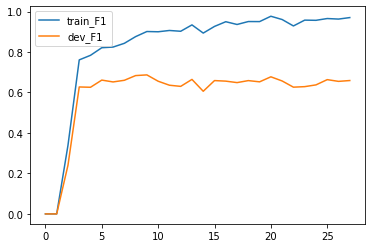

In [10]:
# PURPOSE OF THIS CELL:
# this is the final cell where we train an optimal model. 
# we have now chosen the optimal hyperparameters (lr, wd, epochs)
# we train a nn using the optimal hyperparams on both train+dev combined (more training data than above cell)
# we evaluate on test (in all languages)
# we can use return_df=True to return the test dfs with model scores

# these have already been recorded
#lr_opt = 0.001
#wd_opt = 0.0

args.lr = lr_opt
args.wdecay = wd_opt
#args.nepoch = 70
args.nepoch = epochs_opt

args.final_plot = model_name + "_final_build-test_" + model_name + ".png"
# combines dev and training
def full_train_mlp(args, return_dfs=True, optimize_epochs=False):
        
    liveloss = PlotLosses()

#     train_loader = LoadData(args.base_dir, args.train, args.train_labels,
#                             dim=args.dim, bsize=args.bsize, shuffle=True)

#     train_pos = LoadData_pos(args.base_dir, args.train, args.train_labels,
#                             dim=args.dim, bsize=1, shuffle=True)
    
    train_loader = LoadTrainDevData(args.base_dir, args.train, args.train_labels,
                                    args.dev, args.dev_labels,
                                    dim=args.dim, bsize=args.bsize, shuffle=True)
    
    train_pos = LoadTrainDevData_pos(args.base_dir, args.train, args.train_labels,
                                    args.dev, args.dev_labels,
                                    dim=args.dim, bsize=1, shuffle=True)

    test_loader = LoadData(args.base_dir, args.test+'.en', args.test_labels+'.en',
                          dim=args.dim, bsize=args.bsize, shuffle=False)

    test_text = LoadText(args.base_dir, args.test+'.en', args.test_labels+'.en',
                          dim=args.dim, bsize=args.bsize, shuffle=False)

    
    # set GPU and random seed
    torch.cuda.set_device(args.gpu)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    print(" - setting seed to %d" % args.seed)

    # create network
    net = Net(idim=args.dim, odim=args.nb_classes,
              nhid=args.nhid, dropout=args.dropout, gpu=args.gpu)
    if args.gpu >= 0:
        criterion = nn.CrossEntropyLoss().cuda()
    else:
        criterion = nn.CrossEntropyLoss()

    #optimizer = optim.Adam(net.parameters(), weight_decay=0.0)
    # default: pytorch/optim/adam.py
    # Py0.4: lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False):
    # Py1.0: lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False):
    optimizer = optim.AdamW(net.parameters(),
                           lr=args.lr,
                           weight_decay=args.wdecay,
                           betas=(0.9, 0.999),
                           eps=1e-8,
                           amsgrad=False)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
    #                                                max_lr=args.lr,
    #                                                steps_per_epoch=len(train_loader),
    #                                                epochs=args.nepoch)
    
    epoch_train_loss = []
    epoch_test_loss = []
    epoch_train_f1 = []
    epoch_test_f1 = []
    epoch_id = []
    
    corr_best = 0
    f1_best = 0
    # loop multiple times over the dataset
    for epoch in range(args.nepoch + 1):
        logs = {}

        loss_epoch = 0.0
        print('Ep {:4d}'.format(epoch), end='')
        # for inputs, labels in train_loader:
        for i, data in enumerate(train_loader, 0):
            torch.cuda.empty_cache()
            
            # get the inputs
            inputs, labels = data

            # augment with pos sample
            if data[1][data[1]==1].shape[0] == 0:
                aug_data_pos = iter(train_pos).next()
                inputs = torch.cat([inputs,aug_data_pos[0]])
                labels = torch.cat([labels,aug_data_pos[1]])
            
            labels = labels.long()
            if args.gpu >= 0:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # zero the parameter gradients            
            net.zero_grad()

            # forward + backward + optimize
            net.train(mode=True)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            #for param_group in optimizer.param_groups:
            #    print(param_group['lr'])          
            #scheduler.step()

            loss_epoch += loss.item()
            
        print(' | loss {:e}'.format(loss_epoch), end='')
        print('\n')
        torch.cuda.empty_cache()
        _, _, _, train_clf_reprt = net.TestCorpus_cstm(train_loader, 'Train',nlbl=args.nb_classes)
        torch.cuda.empty_cache()
        del _
        corr, nbex, test_loss, test_clf_reprt = net.TestCorpus_cstm(test_loader, 'Dev', nlbl=args.nb_classes, txt=test_text)
        torch.cuda.empty_cache()
        
        # Epoch metrics (train/dev, loss/F1)
        f1 = test_clf_reprt['1']['f1-score']
        
        epoch_id.append(epoch)
        
        epoch_train_loss.append(loss_epoch/float(i))
        epoch_test_loss.append(test_loss.item())
        
        epoch_train_f1.append(train_clf_reprt['1']['f1-score'])
        epoch_test_f1.append(test_clf_reprt['1']['f1-score'])
        
        
        # Keeping Record of Best MLP net (based on Dev set)
        #if corr >= corr_best:
        if f1 >= f1_best:
            print(' | saved')
            f1_best = f1
            epoch_best = epoch
            net_best = copy.deepcopy(net)
        else:
            print('')
                    
        ## Plot epochs metrics 
        logs['' + 'log loss'] = loss_epoch/float(i)
        logs['' + 'f1'] = train_clf_reprt['1']['f1-score']
        logs['val_' + 'log loss'] = test_loss.item()
        logs['val_' + 'f1'] = test_clf_reprt['1']['f1-score']
        
        liveloss.update(logs)
        liveloss.draw()
        
        torch.cuda.empty_cache()

    plt.plot(epoch_id, epoch_train_loss, label='train_loss')
    plt.plot(epoch_id, epoch_test_loss, label='dev_loss')
    plt.legend(loc='best')
    plt.show()

    plt.plot(epoch_id, epoch_train_f1, label='train_F1')
    plt.plot(epoch_id, epoch_test_f1, label='dev_F1')
    plt.legend(loc='best')
    plt.savefig(args.final_plot)
    

    if optimize_epochs==False: # we want to keep the net trained after epochs_opt epochs, not that which maximizes f1 (cheating!)
        f1_best = f1
        epoch_best = epoch
        net_best = copy.deepcopy(net)
    
    # Saving best MLP net and Producing Zero-Shot Multilingual Results
    if args.save != '':
        torch.save(net_best.cpu(), args.save+'_full')
        print(args.save)
    print('Best Dev: {:d} = {:5.2f}%'.format(epoch_best, 100.0 * f1_best))

    if args.gpu >= 0:
        net_best = net_best.cuda()

    # test on (several) languages
    test_clf_reprt = {}
    
    if return_dfs:
        dfs = {}
    
    for l in args.lang:
        test_loader = LoadData(args.base_dir, args.test + '.' + l,
                               args.test_labels + '.' + l,
                               dim=args.dim, bsize=args.bsize,
                               shuffle=False, quiet=True)

        test_txt = LoadText(args.base_dir, args.test + '.' + l,
                               args.test_labels + '.' + l,
                               dim=args.dim, bsize=args.bsize,
                               shuffle=False, quiet=True)

        print('Ep best | Eval Test lang {:s}'.format(l), end='')
        print('\n')
        _, _, _, test_clf_reprt[l], df = net_best.TestCorpus_cstm(test_loader, 'Test',nlbl=args.nb_classes, txt=test_txt, return_df=True)
        if return_dfs:
            dfs[l] = df
        
        print('\n')
    
    pickle.dump(test_clf_reprt, open( save_model+'_test_metrics_w_full_model.pkl', "wb" ))
    if return_dfs:
        return dfs

#net_best_, test_loader_, nb_classes_, test_txt_, df_ = None, None, None, None, None
dfs = full_train_mlp(args)
#net_best_, test_loader_, nb_classes_, test_txt_

In [11]:
def threshold_analysis(labels, model_scores ,thresholds=np.append(np.arange(0.01,0.98,0.01),np.append(np.arange(0.98,0.999,0.001),np.arange(0.999,1.0,0.00001)))):
    #thresholds = np.arange(0.9,1.00,0.001)
    tps = [sum((labels==1) & (model_scores>=x)) for x in thresholds]
    fps = [sum((labels==0) & (model_scores>=x)) for x in thresholds]
    tns = [sum((labels==0) & (model_scores<x)) for x in thresholds]
    fns = [sum((labels==1) & (model_scores<x)) for x in thresholds]
    precision = [None if (tp+fp)==0 else tp/(tp+fp) for tp,fp in zip(tps,fps)]
    recall = [None if (tp+fn)==0 else tp/(tp+fn) for tp,fn in zip(tps,fns)]
    f1 = [None if (p==None) or (r==None) or (p+r==0) else 2*p*r/(p+r) for p,r in zip(precision, recall)]
    prcurve = pd.DataFrame({'Threshold':thresholds,'F1':f1,'Recall':recall,'Precision':precision,
                           'TP':tps,'FP':fps,'TN':tns,'FN':fns})
    prcurve = prcurve[['Threshold','F1','Recall','Precision','TP','FP','TN','FN']]
    prcurve = prcurve.sort_values(by='F1',ascending=False).reset_index(drop=True)
    return prcurve

In [12]:
df = dfs['en']

print(df)

tp = sum((df.labels==1) & (df.predictions==1))
fp = sum((df.labels==0) & (df.predictions==1))
fn = sum((df.labels==1) & (df.predictions==0))

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)

print('Precision: ' + str(round(precision,2)))
print('Recall: ' + str(round(recall,2)))
print('F1: ' + str(round(f1,2)))

# threshold analysis
prcurve = threshold_analysis(df.labels,df.model_scores)
print('Optimal F1 Score: ' + str(round(prcurve.F1[0], 3)))
prcurve.drop_duplicates(subset='TP')[0:20]

                                                    text  labels  predictions  \
0      it was all that junk from the gallbladder that...       0            0   
1        management reporting group enron europe limited       0            0   
2      last year the colorado oil and gas conservatio...       0            0   
3                                         hows this look       0            0   
4                                   are is the number of       0            0   
...                                                  ...     ...          ...   
34929  ill put calls into voicemail but im not going ...       1            1   
34930      all information is kept strictly confidential       1            1   
34931  from the start ngos opposition parties trade u...       1            1   
34932  i did not tell him anything about the imbedded...       1            0   
34933  i think its best to keep it as close to the ve...       1            1   

       model_scores  
0    

,Threshold,F1,Recall,Precision,TP,FP,TN,FN
0,0.60,0.692228,0.740576,0.649805,334,180,34303,117
1,0.59,0.691992,0.747228,0.644359,337,186,34297,114
2,0.61,0.690302,0.733925,0.651575,331,177,34306,120
4,0.76,0.686461,0.640798,0.739130,289,102,34381,162
5,0.75,0.686251,0.647450,0.730000,292,108,34375,159
6,0.73,0.685912,0.658537,0.715663,297,118,34365,154
7,0.63,0.685714,0.718404,0.655870,324,170,34313,127
8,0.79,0.685435,0.620843,0.765027,280,86,34397,171
9,0.74,0.685250,0.654102,0.719512,295,115,34368,156
10,0.64,0.684492,0.709534,0.661157,320,164,34319,131


In [13]:
df[df.labels==1].head(20)

,text,labels,predictions,model_scores
34483,confidential privileged,1,0,0.318894
34484,please treat as confidential,1,1,0.974988
34485,keep this confidential,1,1,0.981727
34486,not disclose this plan,1,1,0.990353
34487,as for the details about how it makes money en...,1,1,0.976327
34488,davis says he needs secrecy for competitive re...,1,1,0.988139
34489,i neednt be involved and you can know your wor...,1,1,0.973272
34490,i wont tell,1,1,0.989337
34491,im somewhat concerned about the way in which a...,1,0,0.231459
34492,i will of course keep our correspondence on th...,1,1,0.999156


In [14]:
# classificaton report for English
threshold = 0.6
y_pred = [1 if x >= threshold else 0 for x in df.model_scores]
print(classification_report(df.labels, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     34483
           1       0.65      0.74      0.69       451

    accuracy                           0.99     34934
   macro avg       0.82      0.87      0.84     34934
weighted avg       0.99      0.99      0.99     34934



In [15]:
df = dfs['es']

print(df)

tp = sum((df.labels==1) & (df.predictions==1))
fp = sum((df.labels==0) & (df.predictions==1))
fn = sum((df.labels==1) & (df.predictions==0))

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)

print('Precision: ' + str(round(precision,2)))
print('Recall: ' + str(round(recall,2)))
print('F1: ' + str(round(f1,2)))

# threshold analysis
prcurve = threshold_analysis(df.labels,df.model_scores)
print('Optimal F1 Score: ' + str(round(prcurve.F1[0], 3)))
prcurve.drop_duplicates(subset='TP')[0:20]

                                                   text  labels  predictions  \
0                              pero estaban pereciendo        0            0   
1                                         lo es verdad        0            1   
2                   es pequeña pero ya va a la escuela        0            0   
3     sí bueno quiero regresar a tu casa a recoger u...       0            0   
4                                       por favor niña        0            0   
...                                                 ...     ...          ...   
4165                         no lo publicaremos a nadie       1            1   
4166                           nunca hablamos con nadie       1            1   
4167                        trata de no conocer a nadie       1            1   
4168                             son pacíficos porque q       1            0   
4169  es mejor no dar detalles y estás hablando de a...       1            1   

      model_scores  
0         0.005468

,Threshold,F1,Recall,Precision,TP,FP,TN,FN
0,0.94,0.496815,0.433333,0.582090,39,28,4052,51
1,0.93,0.493827,0.444444,0.555556,40,32,4048,50
3,0.95,0.472973,0.388889,0.603448,35,23,4057,55
4,0.91,0.471264,0.455556,0.488095,41,43,4037,49
5,0.88,0.469945,0.477778,0.462366,43,50,4030,47
6,0.96,0.467153,0.355556,0.680851,32,15,4065,58
7,0.89,0.466667,0.466667,0.466667,42,48,4032,48
12,0.80,0.444444,0.511111,0.393162,46,71,4009,44
13,0.83,0.440000,0.488889,0.400000,44,66,4014,46
15,0.81,0.436893,0.500000,0.387931,45,71,4009,45


In [16]:
# classificaton report for English
threshold = 0.94
y_pred = [1 if x >= threshold else 0 for x in df.model_scores]
print(classification_report(df.labels, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4080
           1       0.58      0.43      0.50        90

    accuracy                           0.98      4170
   macro avg       0.78      0.71      0.74      4170
weighted avg       0.98      0.98      0.98      4170



In [ ]:
df = dfs['en']